# Real Estate Investment Opportunity Identification

Predicting whether or not a real estate property is a good candidate for flipping (whether to buy and sell or buy and rent, but in either case, to RENOVATE, for high returns)

Outline

1. Data Wrangling
2. Pre-Processing
3. Modeling
4. Performance

In [89]:
#packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action = 'ignore')

import os
import sys

import cv2 #to read images
import glob #to tell it what kind of files to read within the filepath, in this case .jpg's


import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from tensorflow.keras.utils import to_categorical #np_utils
from tensorflow.keras import layers
from tensorflow.keras.layers import (Flatten, Dense, Activation, MaxPooling2D, Conv2D, InputLayer)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


from numba import double, jit, njit, vectorize

import progressbar

import time

import PIL
from PIL import Image, ImageEnhance

import math

from sklearn.metrics import (confusion_matrix, classification_report, ConfusionMatrixDisplay)
from sklearn.utils import shuffle

import pickle

from skimage.transform import resize   #for resizing images

from moviepy.editor import VideoFileClip, concatenate_videoclips


## 1. Data Wrangling

Since the tool we are making is designed work from images ALONE, the wrangling phase is to get the images into the right format.
##############################

In [90]:
# image paths

#we'll use an ~80/20 split for training/testing

#Training
path_training_flip   = glob.glob('Houses Dataset/Training Set/Flip_Mixed_Training/Flip_Kitchen_Training/*.jpg')
path_training_noflip = glob.glob('Houses Dataset/Training Set/Dont Flip_Mixed_Training/Dont Flip_Kitchen_Training/*.jpg')

#Testing
path_testing_flip   = glob.glob('Houses Dataset/Testing Set/Flip_Mixed_Testing/Flip_Kitchen_Testing/*.jpg')
path_testing_noflip = glob.glob('Houses Dataset/Testing Set/Dont Flip_Mixed_Testing/Dont Flip_Kitchen_Testing/*.jpg')

#glob looks for all files/filepaths that follow/contain a specified pattern, using the *wild card, so here *.jpg!

## 2. Data Preprocessing

Overall Procedure:

    -Generate the training & test images sets, each having a separate one for sell/not sell
    -Make list of labels for the images
    -Combine the training images; Combine the testing images; And same for labels
    -Combine the training images with their labels; Same for testing
    -Shuffle each
    -Separate the labels from the images in each

That will get us Xtest, Xtrain, ytest, ytrain thus readying us for modeling!

In [91]:
# function to preprocess images

def image_preprocessing(path): #works using the filepaths just made
    
    #empty list to store all finished, preprocessed images
    images = []

    #loop through all the path images, preprocessing each one

    for i in path:
        #read the image
        img = cv2.imread(i)
        # Adjust the size so all images will be the same size
        img = cv2.resize(img, dsize = (32,32), interpolation=cv2.INTER_CUBIC)
        #what's right size??
        ########################################################################################
        #interpolation tells it how to "create new pixels" to make the image look smoother as you make it bigger, aka *FILL-IN* the gaps!!!
        #rather than just stretch the original pixels and risking "pixely" images
        #dsize (desired size?) is pixel height/width
        #bicubic is the smoothest cuz it's curved/polynomial

        # Crop to remove excess/unnecessary part of images, like around the border/near the edges, noise, watermarks, text etc
        # this way we can stay focused
        
        #starting/ending pixels
        y, h, x, w = 2, 30, 2, 30
        img = img[y:h, x:w]
        #top is usually just ceiling of room which isn't very useful, unnecessary noise
        

        # Adjust brightness, contrast
        alpha=1.5 #contrast/gain...wait, but then somewhere else it says *WEIGHT* of first image??
        beta=0.5  #brightness/bias..and this says elswhere weight of SECOND image!?!
        #gamma=??
        img = cv2.addWeighted(img, alpha, np.zeros(img.shape, img.dtype), 0, beta)
        #CONFUSED CUZ DOX SHOW THAT ORDER OF ARGS IS (data1, alpha, data2, beta, gamma), thus,
        #IT LOOKS LIKE BETA IS IN *GAMMA'S* SPOT, AND BETA IS BEING SET TO *0*!!!!
        #however, tried both ways/flipping it and didn't seem to make a difference to end outcome!!!
        ########################################################################################
        #addWeighted helps to blend/transition the two images together, by specifiying respective weights / alpha, beta and gamma values, like how visible
        #or transparent one is
        
    
        #so this bitwise_not step along is inversing it, does that mean it alone is making the image grayscale?! or is it only in/w combination w/ the
        #division by 255??
        ########################################################################################
        img = cv2.bitwise_not(img)
        img = img/255               


        #it would seem that dividing by 255 *ISN'T* converting colorscheme to grayscale but rather simply simplifying the RGB numbers of each pixel to something
        #easier to interpret?? b/w 0/1!
        ########################################################################################

        # Append the img to the list images
        images.append(img)

    # Return the list with the preprocessed images
    return images

#okay so overall, this is iterating thru our images in our path folder and reshaping/resizing/recoloring them and
#tryna crop out the background noise as much as possible?

In [92]:
# Read and preprocess the training data

#these are the X's

img_training_flip = image_preprocessing(path_training_flip)

img_training_noflip = image_preprocessing(path_training_noflip)

img_testing_flip = image_preprocessing(path_testing_flip)

img_testing_noflip = image_preprocessing(path_testing_noflip)

In [93]:
#take a look at the pixel RGB expression of the images!
img_training_flip

[array([[[0.7254902 , 0.56862745, 0.34901961],
         [0.61568627, 0.45490196, 0.25490196],
         [0.74509804, 0.54509804, 0.29019608],
         ...,
         [0.76862745, 0.63137255, 0.4745098 ],
         [0.80392157, 0.6745098 , 0.4627451 ],
         [0.40392157, 0.25098039, 0.03921569]],
 
        [[0.59607843, 0.43137255, 0.23137255],
         [0.82745098, 0.67843137, 0.4745098 ],
         [0.66666667, 0.53333333, 0.34509804],
         ...,
         [0.61960784, 0.41568627, 0.18039216],
         [0.78431373, 0.63137255, 0.35686275],
         [0.34117647, 0.20784314, 0.        ]],
 
        [[0.44313725, 0.2745098 , 0.09019608],
         [0.6745098 , 0.49019608, 0.24313725],
         [0.81568627, 0.70196078, 0.45098039],
         ...,
         [0.50196078, 0.33333333, 0.10196078],
         [0.71372549, 0.58039216, 0.28627451],
         [0.64705882, 0.4745098 , 0.20784314]],
 
        ...,
 
        [[0.8627451 , 0.71372549, 0.49803922],
         [0.83137255, 0.70980392, 0.48627

In [94]:
#check you extracted the number of images you were intending in each group. we're trying to have the exact same number for the 2 categories
#to avoid unnecessary class imbalance
#if we see the numbers don't match, that could mean we forgot to change one of the file formats to .jpg (could be .png or .webpage)
len(img_training_flip),len(img_training_noflip),len(img_testing_flip),len(img_testing_noflip)

(69, 69, 17, 17)

In [95]:
# Set the labels

y_train_flip =   [1 for i in range(0, len(img_training_flip))]

y_train_noflip = [0 for i in range(0, len(img_training_noflip))]

y_test_flip =    [1 for i in range(0, len(img_testing_flip))]

y_test_noflip =  [0 for i in range(0, len(img_testing_noflip))]

## 3. Modeling

In [96]:
# Combine the separate categories into X_train, X_test, y_train, y_test

X_train = np.concatenate((img_training_flip, img_training_noflip))

X_test =  np.concatenate((img_testing_flip, img_testing_noflip))

y_train = np.append(y_train_flip, y_train_noflip)

y_test =  np.append(y_test_flip, y_test_noflip)

In [97]:
#view
X_train

array([[[[0.7254902 , 0.56862745, 0.34901961],
         [0.61568627, 0.45490196, 0.25490196],
         [0.74509804, 0.54509804, 0.29019608],
         ...,
         [0.76862745, 0.63137255, 0.4745098 ],
         [0.80392157, 0.6745098 , 0.4627451 ],
         [0.40392157, 0.25098039, 0.03921569]],

        [[0.59607843, 0.43137255, 0.23137255],
         [0.82745098, 0.67843137, 0.4745098 ],
         [0.66666667, 0.53333333, 0.34509804],
         ...,
         [0.61960784, 0.41568627, 0.18039216],
         [0.78431373, 0.63137255, 0.35686275],
         [0.34117647, 0.20784314, 0.        ]],

        [[0.44313725, 0.2745098 , 0.09019608],
         [0.6745098 , 0.49019608, 0.24313725],
         [0.81568627, 0.70196078, 0.45098039],
         ...,
         [0.50196078, 0.33333333, 0.10196078],
         [0.71372549, 0.58039216, 0.28627451],
         [0.64705882, 0.4745098 , 0.20784314]],

        ...,

        [[0.8627451 , 0.71372549, 0.49803922],
         [0.83137255, 0.70980392, 0.48627451]

In [98]:
#see how 
y_test

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
#btw - THIS IS GOOD TO SEE THAT THERE'S COMPLETE SEGREGATION AT THIS POINT BECAUSE THIS SHOWS THE APPENDED*
#/*COMBINED* FLIP/NOT FLIP SET THAT MAKES UP/COMPRISES Y_TEST!!!!!
#later we're gonna SHUFFLE IT UP!

In [100]:
#commented out to avoid stoppage / breakage when running whole notebook!
# img_training_flip.shape
# >> output:
# ---------------------------------------------------------------------------
# AttributeError                            Traceback (most recent call last)
# /var/folders/cr/9gwdd0wn43d9d1db4xfhyvpc0000gn/T/ipykernel_90203/1074584411.py in <module>
# ----> 1 img_training_flip.shape

# AttributeError: 'list' object has no attribute 'shape'

In [101]:
# hain? why is this being treated like a list when it looks exactly like X_train??

In [102]:
# Check if shapes make sense and match requirements

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(138, 28, 28, 3)
(138,)
(34, 28, 28, 3)
(34,)


In [103]:
# # Now combine the images & labels TOGETHER! so that we can SHUFFLE THEM while still keeping the correct labels INTACT! unseparated!
# # we'll have to do this SEPARATELY of course for both training & testing, cuz of leakage/peekage! ("pack"age;P)

# #training

# Xy_train_shuffle = []

# #enumerate() will create a list of tuple pairs: each image +/w its index position!
#     #so i=index of that image, j=image at that index! great couple/tuple pair!
# for i,j in enumerate(X_train):
#     # This will pair the training image itself with its truth LABEL (y)
#     new_array = (j, y_train[i])
#     #populate the list with these labeled images, which we will next shuffle!
#     Xy_train_shuffle.append(new_array)
    
# # Have the new set of arrays
# Xy_train_shuffle = np.array(Xy_train_shuffle)
# #hmmmmm - why do we need to make it an np.array()? so this is like an array of arrays? only works in this format?
    

# #shuffle
# np.random.shuffle(Xy_train_shuffle)


# #NOTE!!!!! YOU DON'T HAVE TO DO ANYTHING TO *SAVE* THE SHUFFLING ORDER!!!
# #in fact, if you save this to a variable, i think when you display that variable, it'll just EXECUTE this code!!!
# #like it's just a *set of instructions/COMMAND!*

In [104]:
#Note, we call it 'X'_test_shuffle & X_train_shuffle, but it's got X+AND+y now...
###*but WE'RE GONNA GO *RIGHT BACK* AND *SEPARATE AGAIN* RIGHT AFTER WE SHUFFLE!!!!!!
#but then we're gonna OVERWRITE the OLD X/y train/tests!!!
############################################################

In [105]:
# #line up the test images with their labels

# Xy_test_shuffle = []

# for i,j in enumerate(X_test):
#     new_array = (j, y_test[i])
#     Xy_test_shuffle.append(new_array)
    
# Xy_test_shuffle = np.array(Xy_test_shuffle)

# #shuffle
# np.random.shuffle(Xy_test_shuffle)

# #BUT DO WE EVEN NEED TO SHUFFLE THE TEST SET?!?!
# ############################################################

In [106]:
Xy_train = np.array(list(zip(X_train,y_train)))

np.random.shuffle(Xy_train)

Xy_train_shuffle = Xy_train

Xy_test = np.array(list(zip(X_test,y_test)))

np.random.shuffle(Xy_test)

Xy_test_shuffle = Xy_test

In [107]:
Xy_test_shuffle

array([[array([[[0.03137255, 0.        , 0.        ],
                [0.09019608, 0.        , 0.        ],
                [0.03137255, 0.        , 0.        ],
                ...,
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ]],

               [[0.01568627, 0.        , 0.        ],
                [0.01960784, 0.        , 0.        ],
                [0.10196078, 0.        , 0.        ],
                ...,
                [0.        , 0.        , 0.        ],
                [0.        , 0.        , 0.        ],
                [0.10980392, 0.        , 0.        ]],

               [[0.19607843, 0.05490196, 0.        ],
                [0.        , 0.        , 0.        ],
                [0.03921569, 0.        , 0.        ],
                ...,
                [0.09019608, 0.        , 0.        ],
                [0.0627451 , 0.        , 0.        ],
               

In [108]:
#hmmm - ... - ahhhh okay - so i guess it's pretty hard to see in this view w/ so many values/pixels but the VERY LAST thing is what i was looking for -
#you see that 0 in the bottom right corner? *THAT MUST BE THE Y-LABEL*!!!!! that's why it's outside alllll the other brackets all on its own/lone/lownsome!!!!!
###########################################################################################################################################################
# but also - WHY ARE THERE SO MANY *ZEROS*?!? well, 0 is white, so...
#could be that this pic has alotta white pixels??
###########################################################################################################################################################
#Also - IS IT SUPPOSED TO BE AN *ARRAY WITHIN AN ARRAY*?!?!

In [109]:
Xy_test_shuffle.shape

(34, 2)

In [110]:
#Now that test & train are each shuffled, separate the y labels back off from each of them since model training/testing/predicting requires
#separation of X & y!
#peel the meat off the bone

#but i guess since this isn't a dataframe, and maybe *can't* be a dataframe? it's not easy to separate...
#unlesss,... IF WE MADE *EACH* OF RGB ITS OWN COLUMN!!!!!!

#but, otherwise - this what we'll have to do:

#we already have these arrays w/ these names, but remem they contained ONLY X/y, respectively, and obviously weren't SHUFFLED at the time!
#so we're just gonna replace/overwrite these w/ synchronized-shuffled pairs independently!
X_train_shuffled = []
y_train_shuffled = []

#loop thru the combined/lined up training set, and send the image to X_train and the label to y_train!!!!
for i in Xy_train_shuffle:  #remem, X_train_shuffle is a set of shuffled up PAIRS of images w/ their corresponding values
                           #so that's the great thing - we don't risk mixing up the data since we're shuffling PAIRS!!! keeping them intact
    
    #so each 'i' is a tuple pair of (image, value)
    # The array containing the picture would be the one that is in the index 0
    image = i[0] #ohh okay, so this is referencing the 0-index of EACH i-element-tuple-pair within X_train_shuffle,
    #which is the IMAGE!! cuz i([[0],[1]]) = X_train_shuffle([[0],[1]]) = X_train_shuffle([[image],[value]])!!!
    # The label would be the array that is on the index 1
    label = i[1] #and so the 1-index-position of each tuple-pair-element in X_train_shuffle is the value!!!
    
    # Append the values and the labels to separate arrays

    #REALLY WE COULD *SKIP* THE ABOVE/HELPER AND JUST GO *DIRECTLY* TO THE APPEND, ONCE AGAIN?!
    X_train_shuffled.append(image)
    y_train_shuffled.append(label)

#so it's just peeling apart / separating out the pair into it's parts! and putting into the respective bucket/bins/indep lists!
#: 1st element / value / X / image into the X list and 2nd element / label / y / classifier to the y list!

#hmmm okay, so now we store ALL the X_train images in one list(? or array?), SHUFFLED
#oh - check below - again, not shure why didn't make arrays directly up here but yeah, these above as they stand are LISTS!
#and do the same for the y-values
#BUT REMEMBER! they were shuffled TOGETHER! as PAIRS! so these will STILL line up if we wanna join em back together!
#and if they're lists we can even re-tuple/combine them now easily!


#but again - question is - why do we wanna separate em into diff lists? i get it tho that if this is something we wanted
#to do, we couldn't have simply taken these lists independently CUZ THE WHOLE POINT WAS TO TUPLE-PAIR-TIE THEM!!!
    
#but is it necessary to do a for loop to get the 'columns' of this tupled array? hmm doesn't seem so - remem how this
#'tupled' array object looks like? seems to behave how you'd expect off that - nothing you can really do w/ it?


X_train_shuffled = np.array(X_train_shuffled)

y_train_shuffled = np.array(y_train_shuffled)

In [111]:
#ohhhhhhh, interesting....... so we 'converted' these to just *2* dimensions?.... i was thinking since we added on y labels, that we made like a *5th*
#dimension!?! lol, but i guess we simplified it and like 'compressed' it to a 2dimensional shape, even tho you still see the many sets of brackets
#but yeah, i guess now it's SIMPLE! the dimensions represent the 47 test images, and the 2 is....???
###########################################################################################################################################################

In [112]:
Xy_train_shuffle.shape

(138, 2)

In [113]:
#okay, at least that's what we expected, meaning based on what we just saw w/ test shuffle, aka only the first term is changing and reflects
#the number of samples!

In [114]:
# Same for test

X_test_shuffled = []
y_test_shuffled = []

# Start a for loop into the X_test_shuffle
for i in Xy_test_shuffle:
    # The array containing the picture would be the one that is in the index 0
    image = i[0]
    # The label would be the array that is on the index 1
    label = i[1]
    # Append the values and the labels to separate arrays
    X_test_shuffled.append(image)
    y_test_shuffled.append(label)

X_test_shuffled = np.array(X_test_shuffled)

y_test_shuffled = np.array(y_test_shuffled)

In [115]:
# Make sure shapes are the same as their originals
#bc at this point, now that we SEPARATED again, we're BACK TO WHERE WE STARTED in terms of SHAPE/SIZE!!! w/as the originalal X/y train/test!!!
#bc all we did after all/that was essentially SHUFFLE it!!! so these are all the SAME *SET* of data as their original, - didn't alter / edit / add /
#remove any data/points!, - they're just in a different ORDER!!!
#and the great thing is that, even tho they're SEPARATED, they're STILL *LINED UP*!!!!
#lol, like when a severed hand (Allah protect us!!!!) can still move/be controlled by the brain! (is that true?)

#we could've given these new names ofc btw, instead of overwrite, but i guess one approach / preference / advantage is having LESS variables!
#other times/perspective is that's GOOD cuz advantage is keeping things SEPARATE and keeping a TRACK/RECORD / PAPER TRAIL!

#if give new names above so we can differentiate and keep rather than overwrite and compare side by side here!
#but if not, just scroll up or do side-by-side to when we did it last!
#can make nice like put text like: print('The shape of X_train originally was %X_train.shape% and now it is %X_train_shuffled.shape%')
print(X_train_shuffled.shape)
print(y_train_shuffled.shape)
print(X_test_shuffled.shape)
print(y_test_shuffled.shape)

(138, 28, 28, 3)
(138,)
(34, 28, 28, 3)
(34,)


In [116]:
# Function for neural networks

def neural_network():  #if it has no args then that's really easy - will just execute code body as is! that means there's no OUTSIDE variables / params it's dependent on!
    model = Sequential()
    #dox: "Sequential groups a linear stack of layers into a tf.keras.Model."
    #"A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor."
    #so i guess for us, that's One Image, One Label??
    ############################################
    #interestingly, Sequential has very very little args, which is prob why we usually see it BLANK like here!
    #and why it seems to be the norm to do what he does below, which is "ADD" THINGS TO IT!!!!
    
    model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', kernel_initializer='he_uniform', input_shape=(28, 28, 3))) #don't remember why, but i tried it with removing kernel initializer to let it default, which apparently is to 'glorot_uniform'?
    #About Conv2D:
#"2D convolution layer (e.g. spatial convolution over images)"
#"This layer creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs. If use_bias is True, a bias vector is created and added to the outputs. Finally, if activation is not None, it is applied to the outputs as well."
    
    #32 should be the FILTERS - but not sure what that is... says: "Integer, the dimensionality of the output space (i.e. the number of output filters
        #in the convolution)."
        #SO NOT SURE HOW HE GET 32?!? AND WHAT IT'D BE FOR US?!
        ############################################
    #(3,3) should be 'kernel size', for the 'height/width' of the 2D 'convolution window'....
        #so don't know how to determine what this should be!
        ############################################
    #activation - the activation function to use. don't know what this means.... &don't know what other choices there are. won't use any if don't specify
    ############################################
    #padding: not sure what padding is, but says: " "same" results in padding with zeros evenly to the left/right or up/down of the input."
    #input_shape is just the shape of the images! 28x28 RGB pixels!

    #AND THERE ARE MANY OTHER ARGS JUST FOR THIS!!!!!

    model.add(MaxPooling2D((2, 2)))
    #a little on MaxPooling2D:
    #"Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window
    #(of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension."
    #the (2,2) should be 'pool_size'
    #"integer or tuple of 2 integers, window size over which to take the maximum. (2, 2) will take the max value over a 2x2 pooling window.
    #If only one integer is specified, the same window length will be used for both dimensions."
        #lol so we could just write 2 ALONE?! like, not even in parenths?! ;D
        #but yeah - no idea what this means - what's a window/size, what max??
        #WHAT VALUE SHOULD WE DO?!
        ########################################################################

    model.add(Flatten())
    #"Flattens the input. Does not affect the batch size."
    #only arg this has is 'data_format', which defaults to 'channels_last'
    #don't know what this really means
    ########################################################################
    
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform')) #don't remember why, but i tried it with removing kernel initializer to let it default, which apparently is to 'glorot_uniform'?
    #"Just your regular densely-connected NN layer"
    #"Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as
    #the activation argument, kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer"
    # 128 is the 'units': "Positive integer, dimensionality of the output space." ? -> but SAME THING that *FILTERS* said above!in Conv2D
    #again, no idea what this really means or what these args do and if these vals are appropriate here, or if we needa specify MORE/different ones...
    ########################################################################
    
    model.add(Dense(1, activation='sigmoid'))
    #oh.... so, we meet again? so is it like for every 'dense layer' we want, we just add another line for it separately??
    #why 1? why diff activation??

    #man, this'll be hard to GridSearch! how do you do it when you're working with *ADDS* and not NATIVE ARGS TO THE MODEL THEMSELVES?!?!
    ######################################################################################################################################################

    #optimizer
    opt = SGD(lr=0.001, momentum=.9)
    #"Gradient descent (with momentum) optimizer."
    #has a bunch of args... how do i know what to pick?! and idk how you'd GridSearchCV this, cuz again this is ANOTHER SEPARATE THING OUTSIDE OF THE
    #MODEL ITSELF!
    
    # compile model
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    #optimizer goes here
    #loss function - THIS IS WHAT WE WANT TO *MINIMIZE*!!!! LIKE IN REGRESSION THERE'S MSE!!!
    #never heard of binary_crossentropy, but it's in the list of 'probabilistic losses'... stuff i recognize, like MSE, is in the 'Regression Losses' section!
    #OHHH - so R2 and Accuracy wouldn't be in 'Loss' cuz these are NEGATIVES, aka telling us what we DIDN'T get, aka the GAP! THAT'S WHY WE WANNA
    #*MINIMIZE* THEM!!!!! r2/accuracy we wanna MAXIMIZE!!! and so that's where *METRIC*, the next arg, COMES IN!!!!!
    #gives us that flexibility there! metrics can go EITHER direction, positive or negative, aka what you got or what you didn't get
    #metrics are what we know for scoring, Accuracy, MSE, etc. so then yeah, like you could have MSE in/for both loss & metrics?
    #oh but wait - can you ever get BOTH MSE &AND* ACCURACY?! cuz accuracy is for DISCRETE/binary stuff, vs. MSE is for CONTINUOUS!
    #OH! well, i guess you COULD still get MSE for binary like if you put it on a CONTINUUM like bayes/logistic where you have a PROBABILITY b/w 0 to 1
    #to show how close to 0 &/vs. how close to 1?! cuz yeah like if you had 2 models you wanted to compare, don't just do raw binary accuracy, but HOW CLOSE
    #WERE THEY TO ACTUALS! like how if there's a pass/fail exam, or two kids graduated,
    #THEY MAY STAND/RANK VERY DIFFERENTLY ON THAT SPECTRUM OF "PASS"!!!
    ######################################################################################################################################################
    #but say just theoretically you have loss as say MSE but metrics as Accuracy, then it's still gonna only optimize on/minimize MSE, but it'll *RECORD* Accuracy too?
    #but note, this isn't like *CROSS-VALIDATION*!!! it's just gonna tell you what it is for THIS very particular model and hyper/param combination!
    #you're on  your own if you wanna cross-validate and compare accuracies to determine the best model!!

    #and there's others/args

    return model



In [117]:
#sA - w/ all these variables/args, WE COULD RUN A GRIDSEARCH kfCV TO SEE WHICH DOES BEST!!!!!!

In [118]:
# Fit model

#little confusing - so we're naming our call of the neural_network function as 'model'
#but in the function model = Sequential()
#and then everything is built on top of / supplemented to 'model'
#like what would happen if we named the below something else? is it like w/ the way we wrote the function they/it has
#to match?

model = neural_network() #so we're relegating/delegating RIGHT to our function! which is a *SEQUENTIAL()* NEURAL NETWORK()!!!!! w/ all those fixin's hon!

# fit model
model.fit(X_train_shuffled, y_train_shuffled, epochs = 15)

#epochs are the number of like runs?
#default=1
#is this what we saw w/ NUTS??
#About .fit() in general:
#"Trains the model for a fixed number of epochs (iterations on a dataset)."
#About epochs arg:
#"An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch,
#epochs is to be understood as "final epoch".The model is not trained for a number of iterations given by epochs,
#but merely until the epoch of index epochs is reached."
#so the last part seems to contradict the intro right above it?! about .fit()?!
####################################################################################################################################
#so it's how many times it goes thru ALL the data...but like, isn't it just supposed to go thru the data....once.....?
#yeah still not clear on what epoch is...
#seems like it's tryna say it's not 'TRAINING' on the data this many times, which yeah makes sense, but then it seems like it's saying it's the number
#of iterations THRU the data, aka ALL of the data.....
#so yeah, why then would you needa go thru it more than once?
#UNLESSSSS...it's saying it's like the number of like SEGMENTS/*CHUNKS* WE WANNA BREAK UP THE DATASET INTO?!?
#in NUTS it was like the number of INDEPENDENT SIMULATIONS! like same PARAMS, but cuz of RANDOMNESS, good to see what happens if you do again, just to make
#sure it's consistent and what you're getting isn't some serious FLUKE! so typically you'd do 2 or - actually i guess it makes sense to do *3*, cuz it could
#happen that ONE is a very rare fluke, but if you only do *2*, you may not know WHICH ONE!? but if you do 3, you'll know which is the ODD MAN OUT!!!!
####################################################################################################################################

Epoch 1/15
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 0s 4ms/step - loss: 0.7519 - accuracy: 0.5030
Epoch 2/15
5/5 [==============================] - 0s 5ms/step - loss: 0.6599 - accuracy: 0.5625
Epoch 3/15
5/5 [==============================] - 0s 5ms/step - loss: 0.5866 - accuracy: 0.6926
Epoch 4/15
5/5 [==============================] - 0s 6ms/step - loss: 0.5577 -

In [119]:
#ohhh, interesting - so it tells you the loss & accuracy metrics right here!
#AHHH - interesting - *THE GENERAL TREND IS THAT IT GETS *BETTER* W/ EACH EPOCH!*
#aka accuracy goes up and loss goes down! improves *ALOT* by the end!!!!
#very last one tho regresses just ever so slightly, not signif
#WHY IS THAT/HOW DOES IT WORK?!
#this makes it seem like it *IS* redoing the WHOLE thing each time and like training/retraining itself to "self-improve"!!!
#rather than the 'chunks' idea!
#also notice the '5/5' in each! is that like... FOLDS?!
#remem tho - this is only TRAINING!!!/FITTING! so how do we have loss/accuracy? well we know we CAN have that w/ the training set,
#like fit the training, so is that what it's doing?!
########################################################################

In [120]:
#hmm so even tho i disabled warnings, still got some here!:
# Epoch 1/15
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2940840d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_train_function.<locals>.train_function at 0x2940840d0> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

# 2023-01-17 10:15:55.484304: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
# 2023-01-17 10:15:55.484635: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz

In [121]:
#oh lol, it does say within that:
#"To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert"

In [122]:
# Predict the test set

predictions = model.predict(X_test_shuffled)

# So this model, like Bayes/Logistic, won't give us straight BINARY 0/1 PREDICTIONS, but rather a *PROBABILITY*!!!! CONTINUOUS FROM 0.0 TO 1.0!
# So we need to get a BINARY version of the predictions using rounding
# And this ofc can be custom of our choice - doesn't have to be @/on .5! we can play around w/ this to see if it helps us!?
################################################################################################################################################

#give it its own list
binary_values = []

#get a binary equivalent for each continuous predictions iteratively
for i in predictions:
    if i < 0.5:
        binary_values.append(0)
    if i >= 0.5:  ############OH WAIT! can't we just simplify this to 'else binary_values.append(1)'?!?!?!?############
        binary_values.append(1)

#####SO THIS IS ANOTHER THING WE COULD DO CROSS-VALIDATION ON!!!!*******

###haha sweet sweet innocent beginnings :')
#but how does it know what a 0 means and what a 1 means? like we assigned the 0's and 1's earlier for/as the
#correct answers. but how does it know to call a flip a 1 and a don't flip a 0?
#ohhh okay i get it! so we TRAINED it to identify things as either a 0 or a 1!!! cuz it can only understand numbers!
#it has no idea what they actually are or what they mean/represent!!! thus its PREDICTIONS will be like a weighted (is that the right word? but you've got the right idea/on the right track) #lollll - as teachers said in elementary school: "on the right track, but on the wrong train" ;P!!!!!
#average of how much it leans toward it being a 0/notflip or 1/flip. and we force it to pick one cuz ultimately it
#needs to make a decision. in the final analysis of accuracy since there's diff metrics i'm sure there's one that looks
#at the actual value to see how close it was >> LIKE *MSE*!!!. kinda like pass/fail but there of course still has to be an actual score!
#it's just that you have to draw a line/make a cutoff somewhere
        

#so like if we're classifying 2 things/choices, it can only be one or the other, but it will spit back
#like *HOW MUCH IT THINKS/leans toward it being one or the other*!!!!, and so we have to tell it at what point/percentage/
#confidence we want it to make a call for one or the other, what's the defining/differentiating/determining/identifying/distinguishing/DECISION line?!!!
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [123]:
#same warning displayed as (the first/main/big portion of) above:
# WARNING:tensorflow:AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x294774550> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
# WARNING: AutoGraph could not transform <function Model.make_predict_function.<locals>.predict_function at 0x294774550> and will run it as-is.
# Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
# Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
# To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

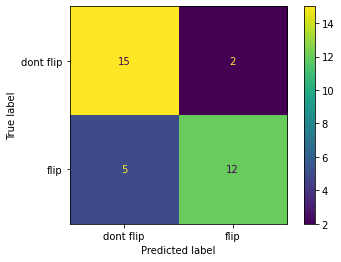

In [124]:
#confusion matrix

cm = confusion_matrix(y_test_shuffled, binary_values)
#so the y_test is now giving the ANSWER KEY so the algorithm can see how it did / its performance on this test/section
#so we gave the algo/machine this test set of images, combined flip and not flip so it didn't know which was which,
#all it had was the model it was trained on w/ the training set of images and corresponding labels. that was the
#instruction/guided section. this was its turn to do it on its own/try its hand at it, no more open-book/hand-holding,
#to see how well it learned/how well it can do on its OWN! on 'un(before)seen data'!/problems
#so you see that it's actually very simple here, it's comparing the machine's answers, in 'binary_values', defined/
#assigned above, and comparing them to the CORRECT ANSWERS, as defined by us in y_test!!! confusion matrix is simply
#just a visual tool to help us see the performance w/ machine learning prediction performance

cmd = ConfusionMatrixDisplay(cm, display_labels=['dont flip','flip'])
cmd.plot();

In [125]:
#so of the 27 test dontflips, we correctly got 19. so 19/27 ≈ 70%
# & of the 20 test DO-FLIPS,  we correctly got 15, so 15/20 = 75%!
#okay, well, aH, at least pretty CONSISTENT!

#we can look at which ones IT GOT WRONG!!!! to see if there are any PATTERNS on something that's THROWING IT OFF!?!?
#(and also which it got RIGHT!)

In [126]:
#OHHH - WE SHOULDA TRIED TO MAKE THEM MORE *EVEN* FOR EACH MAYBE?!?! like number of flips/non-flips in both training & test to avoid RATIO/CLASS IMBALANCE/BIAS!!!!
################################################################################################################################################
#so like we SHOULDN'T have it train on numbers that reflect the actual POPULATION!?! cuz like - then it might kinda go into that mode of like when
#you see like 4 answer choice C's in a row, like no - can't be 'C' again! or if smarter, think like, ONE OF THESE must not be C!!!
#it's gotta have that / any noise like that COMPLETELY OUT OF ITS MIND!!!!!

In [127]:
#Classification Report to check metrics like Accuracy
print(classification_report(y_test_shuffled, binary_values))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        17
           1       0.86      0.71      0.77        17

    accuracy                           0.79        34
   macro avg       0.80      0.79      0.79        34
weighted avg       0.80      0.79      0.79        34



In [128]:
#yep, so, makes perfect sense - avg b/w 70 & 75 is 72/73!

#*ALSO*! in the TRAINING EPOCHS, we got a range of accuracy from .52 to .90, which *ALSO AVGS TO AROUND THE SAME*!!!! OF/@ 71.5%!!!

In [129]:
#remember it's not just like - if it looks like these, FLIP, if not, DON'T!
#it's if it looks like THESE OTHER ONES, DON'T FLIP!!!!
#aka, even though it's binary, YOU STILL GOTTA SHOW IT EXAMPLES OF WHAT *NOT* TO DO!!!!
#cuz like there may be other areas in between that we're NOT covering!!! we're focused on a specific RANGE!
#it's just like how WE/a KID learns!!! also needa be shown *EXAMPLES* of what *NOT* to do!!!!
########################################################################################

In [130]:
#what's the best way to see which images it identified as which, esp the wrong ones?
########################################################################################

### Conclusion

I was able to create a model with 0.__ accuracy for whether a page needs to be flipped or not by using deep learning and doing the necessary data preprocessing such as making all the images black & white, all the same size, cropping them, adjusting brightness, adding noise, etc.

In [131]:
# Save the model using pickle

#doesn't say pickle anywhere??? lol we did import it at start/top tho

model_classifier = model.save('flip_page_classifier')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: flip_page_classifier/assets


In [132]:
#errors?^